## EX 02

In [31]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('../data/checking-logs.sqlite')

# Загружаем данные коммитов без админов
query = """
SELECT timestamp
FROM checker
WHERE uid NOT LIKE 'admin%'
"""
df = pd.read_sql(query, conn)
conn.close()

# Преобразуем в datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Функция для определения периода суток
def time_of_day(t):
    hour = t.hour
    if 0 <= hour <= 3:
        return 'night'
    elif 4 <= hour <= 9:
        return 'morning'
    elif 10 <= hour <= 16:
        return 'afternoon'
    else:
        return 'evening'

# Создаём столбец с периодом суток
df['time_of_day'] = df['timestamp'].apply(time_of_day)

# Создаём столбец с датой (без времени)
df['date'] = df['timestamp'].dt.date

In [32]:
df

,timestamp,time_of_day,date
0,2020-04-17 05:19:02.744528,morning,2020-04-17
1,2020-04-17 05:22:35.249331,morning,2020-04-17
2,2020-04-17 05:22:45.549397,morning,2020-04-17
3,2020-04-17 05:34:14.691200,morning,2020-04-17
4,2020-04-17 05:34:24.422370,morning,2020-04-17
...,...,...,...
3202,2020-05-21 20:19:06.872761,evening,2020-05-21
3203,2020-05-21 20:22:41.785725,evening,2020-05-21
3204,2020-05-21 20:22:41.877806,evening,2020-05-21
3205,2020-05-21 20:37:00.129678,evening,2020-05-21


In [33]:
# Считаем коммиты по дате и времени суток
commits_grouped = df.groupby(['date', 'time_of_day']).size()
commits_grouped

date        time_of_day
2020-04-17  afternoon      10
            morning        13
2020-04-18  afternoon      33
            evening        35
            morning         1
                           ..
2020-05-20  evening        10
            morning         7
2020-05-21  afternoon      27
            evening        21
            morning         1
Length: 90, dtype: int64

In [34]:
period_counts = commits_grouped.unstack(fill_value=0)
period_counts

period_order = ['night', 'morning', 'afternoon', 'evening']
period_counts_sorted = period_counts.reindex(columns=period_order, fill_value=0)
period_counts_sorted

time_of_day,night,morning,afternoon,evening
date,,,,
2020-04-17,0,13,10,0
2020-04-18,0,1,33,35
2020-04-19,2,4,16,11
2020-04-20,0,0,12,13
2020-04-21,0,0,0,25
2020-04-22,0,0,4,24
2020-04-23,2,6,15,20
2020-04-24,0,0,4,12
2020-04-25,1,21,33,49


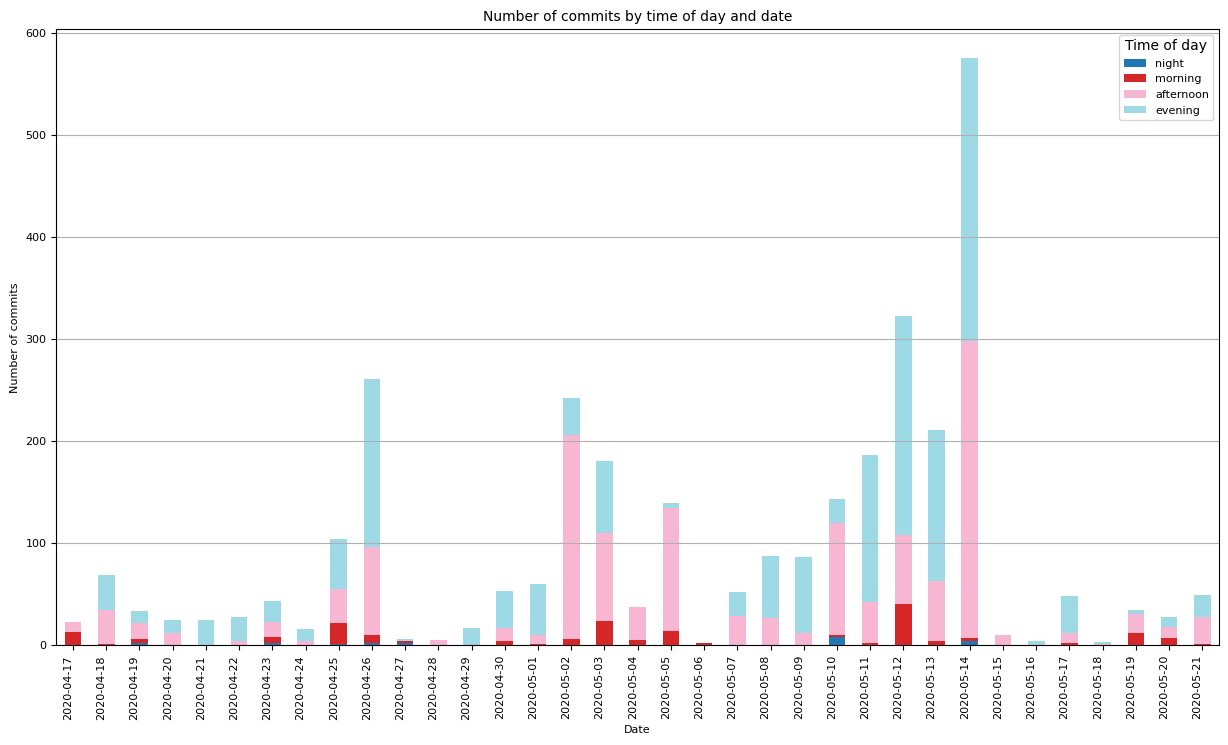

In [35]:
# Строим график
ax = period_counts_sorted.plot(
    kind='bar',
    stacked=True,
    figsize=(15,8),
    fontsize=8,
    colormap='tab20'  # можно выбрать любую палитру, например 'tab20'
)

ax.set_title("Number of commits by time of day and date", fontsize=10)
ax.set_xlabel("Date", fontsize=8)
ax.set_ylabel("Number of commits", fontsize=8)
ax.legend(title='Time of day', fontsize=8)

# Поворачиваем подписи оси X для удобства
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.grid(axis='y')

####  --- Анализ вопросов ---

#### Два самых частых периода времени по всем данным

In [36]:
total_commits_by_period = df['time_of_day'].value_counts()
top_two_periods = total_commits_by_period.nlargest(2).index.tolist()

print("The answer is:", top_two_periods)

The answer is: ['evening', 'afternoon']


#### День с максимальным количеством коммитов, где вечером больше, чем днём

In [37]:
period_counts_sorted['total'] = period_counts_sorted.sum(axis=1)
filtered = period_counts_sorted[period_counts_sorted['evening'] > period_counts_sorted['afternoon']]
if not filtered.empty:
    max_total_day = filtered['total'].idxmax()
    print("The day with the most commits and evening > afternoon is:", max_total_day)
else:
    print("No day found where evening commits are greater than afternoon commits.")

The day with the most commits and evening > afternoon is: 2020-05-12
